In [1]:
import zipfile, io
import os
import re
import glob

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def moving_average(data, window):
    padding_num = int(np.floor(window / 2))
    start_padding = data[:padding_num].mean().repeat(padding_num)
    end_padding = data[len(data)-padding_num:].mean().repeat(padding_num)

    values = np.concatenate([start_padding, data, end_padding])

    ret = np.cumsum(values, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window


class MovingAverager:
    def __init__(self, windows):
        if isinstance(windows, List):
            self.windows = windows
        elif isinstance(windows, int):
            self.windows = [windows]
        self.max_window = max(self.windows)
    
    def execute(self, data):
        assert len(data) >= self.max_window
        
        result = np.zeros(len(data))

        for window in self.windows:
            result += moving_average(data=data, window=window)
        result /= len(self.windows)

        return result

In [3]:
def read_from_folder(folder):
    acc_df = pd.read_csv(os.path.join(folder, 'Accelerometer.csv'))
    lin_acc_df = pd.read_csv(os.path.join(folder, 'Linear Accelerometer.csv'))
    mag_df = pd.read_csv(os.path.join(folder, 'Magnetometer.csv'))
    gyro_df = pd.read_csv(os.path.join(folder, 'Gyroscope.csv'))
    
    total_df = pd.concat([acc_df, gyro_df, lin_acc_df, mag_df], axis=1)
    return total_df


def rename_data(df):
#     new_names = ['acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    new_names = ['times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    return df


def gen_total_mag(df: pd.DataFrame):
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    return df


def smooth(df):
    for column in df.columns:
        if 'time' in column:
            continue
        df[column] = moving_average(df[column], 5)
    return df


def select_data(df):
    return df[['times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t']]


def bound_range(df, datapoint_per_second=20):
    start = int(datapoint_per_second * 1.0)
    end = int(len(df) - datapoint_per_second * 1.0)
    
    return df.iloc[start:end].reset_index(drop=True)


def load_data(folder):
    total_df = read_from_folder(folder)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    
    total_df = gen_total_mag(total_df)
    total_df = smooth(total_df)
    
    total_df = select_data(total_df)
    total_df = bound_range(total_df)
    
    return total_df

In [4]:
all_data = {}

for user_folder in sorted(glob.glob('./R403_trajectory/user*')):
    user = user_folder.split('/')[-1]
    all_data[user] = {}
    
    for path_folder in sorted(glob.glob(os.path.join(user_folder, 'Path*'))):   
        path = path_folder.split('/')[-1]
#         try:
        temp = {}
        for i, posture_folder in enumerate(sorted(glob.glob(os.path.join(path_folder, '*[!zip]')))):
            posture = posture_folder.split('/')[-1]
            
            print(posture_folder)

            df = load_data(posture_folder)
            temp[posture] = df.to_numpy()
                
#         except Exception as e:
#             print(path_folder)
#             print(e)
#             continue
        
        all_data[user][path] = temp

./R403_trajectory/user1/Path1/front_pocket
./R403_trajectory/user1/Path1/horizontal
./R403_trajectory/user1/Path1/pocket
./R403_trajectory/user1/Path1/swing
./R403_trajectory/user1/Path1/target
./R403_trajectory/user1/Path2/front_pocket
./R403_trajectory/user1/Path2/horizontal
./R403_trajectory/user1/Path2/pocket
./R403_trajectory/user1/Path2/swing
./R403_trajectory/user1/Path2/target
./R403_trajectory/user1/Path4/front_pocket
./R403_trajectory/user1/Path4/horizontal
./R403_trajectory/user1/Path4/pocket
./R403_trajectory/user1/Path4/swing
./R403_trajectory/user1/Path4/target
./R403_trajectory/user1/Path5/front_pocket
./R403_trajectory/user1/Path5/horizontal
./R403_trajectory/user1/Path5/pocket
./R403_trajectory/user1/Path5/swing
./R403_trajectory/user1/Path5/target
./R403_trajectory/user2/Path1/front_pocket
./R403_trajectory/user2/Path1/horizontal
./R403_trajectory/user2/Path1/pocket
./R403_trajectory/user2/Path1/swing
./R403_trajectory/user2/Path1/target
./R403_trajectory/user2/Path2/

In [5]:
def read_data(path):
    data = []
    
    for file_path in glob.glob(f'{path}/**/Magnetometer.csv', recursive=True):
        df = pd.read_csv(file_path, delimiter='\t')
        cord = file_path.split('/')[-2].split('_')[2:]
        cord = (float(cord[0]), float(cord[1]))
        
        mean_mag = df[["X (µT)", "Y (µT)", "Z (µT)"]].mean().to_numpy()
#         data.append(np.concatenate((cord, mean_mag)))
        data.append(np.concatenate((cord, mean_mag)))
        
    return np.array(data)

# grid_data = read_data('/root/Calibration/PhyPhox/Grid/')
# grid_data[:, :2] = grid_data[:, :2] - np.array((1, 1))
# grid_data = grid_data[np.lexsort((grid_data[:, 1], grid_data[:, 0]))]
# grid_data.shape

In [6]:
class DataInterpolator:
    def __init__(self, file_path):
        self.data = np.load(file_path)
        self.validate_data()
        self.transform_data()
        self.mark_forbidden_zones()
        self.shape = self.grid.shape

    def validate_data(self):
        assert self.data.shape[1] == 6, "Data must be of shape (n, 6)"

    def transform_data(self):
        x = self.data[:, 0].astype(int)
        y = self.data[:, 1].astype(int)
        additional_data = self.data[:, 0:6]
        x_max = x.max() + 1
        y_max = y.max() + 1
        self.grid = np.zeros((x_max, y_max, 6))
        for i in range(self.data.shape[0]):
            self.grid[x[i], y[i], :] = additional_data[i]

    def mark_forbidden_zones(self):
        self.forbidden = np.zeros(self.grid.shape[:2], dtype=bool)
        forbidden_indices = [(9, 7), (9, 8), (9, 9), (10, 7), (10, 8), (10, 9), (11, 7), (11, 8), (11, 9)]
        for x, y in forbidden_indices:
            if 0 <= x < self.grid.shape[0] and 0 <= y < self.grid.shape[1]:
                self.forbidden[x, y] = True
                self.grid[x, y] = np.array([x, y, 0, 0, 0, 0])

    def bilinear_interpolation(self, x, y):
        x_floor = np.floor(x).astype(int)
        x_ceil = np.ceil(x).astype(int)
        y_floor = np.floor(y).astype(int)
        y_ceil = np.ceil(y).astype(int)
        
        # Find valid corners
        corners = [(x_floor, y_floor), (x_ceil, y_floor), (x_floor, y_ceil), (x_ceil, y_ceil)]
        valid_corners = [(xi, yi) for xi, yi in corners if 0 <= xi < self.grid.shape[0] and 0 <= yi < self.grid.shape[1] and not self.forbidden[xi, yi]]

        # Use only valid points for interpolation
        if not valid_corners:
            raise ValueError("No valid corners available for interpolation.")
        
        interpolated_vector = np.zeros(4)
        total_weight = 0
        for xi, yi in valid_corners:
            weight = (1 - abs(x - xi)) * (1 - abs(y - yi))
            interpolated_vector += weight * self.grid[xi, yi, 2:]
            total_weight += weight

        if total_weight > 0:
            interpolated_vector /= total_weight

        return interpolated_vector
    
    def __getitem__(self, tup):
        try:
            return self.grid[tup[0], tup[1], 2:]
        except:
            if type[tup] is np.array:
                return np.array([self.bilinear_interpolation(i, j) for i, j in tup])
            else: return self.bilinear_interpolation(tup[0], tup[1])
    

# 使用範例
grid = DataInterpolator('npys/grids.npy')
grid.shape

(32, 19, 6)

In [7]:
user_path = defaultdict(dict)

for folder in glob.glob('./user_path/*.npy'):
    print(folder)
    user_name = re.search(r'user\d', folder)[0]
    
    paths = np.load(folder, allow_pickle=True)
    
    for i in range(len(paths)):
        user_path[user_name][f'Path{i+1}'] = paths[i]

./user_path/user2_path.npy
./user_path/user1_path.npy
./user_path/user4_path.npy
./user_path/user3_path.npy


In [9]:
# grids = np.array(grids)
# grid_data = grids[np.lexsort((grids[:, 1], grids[:, 0]))]

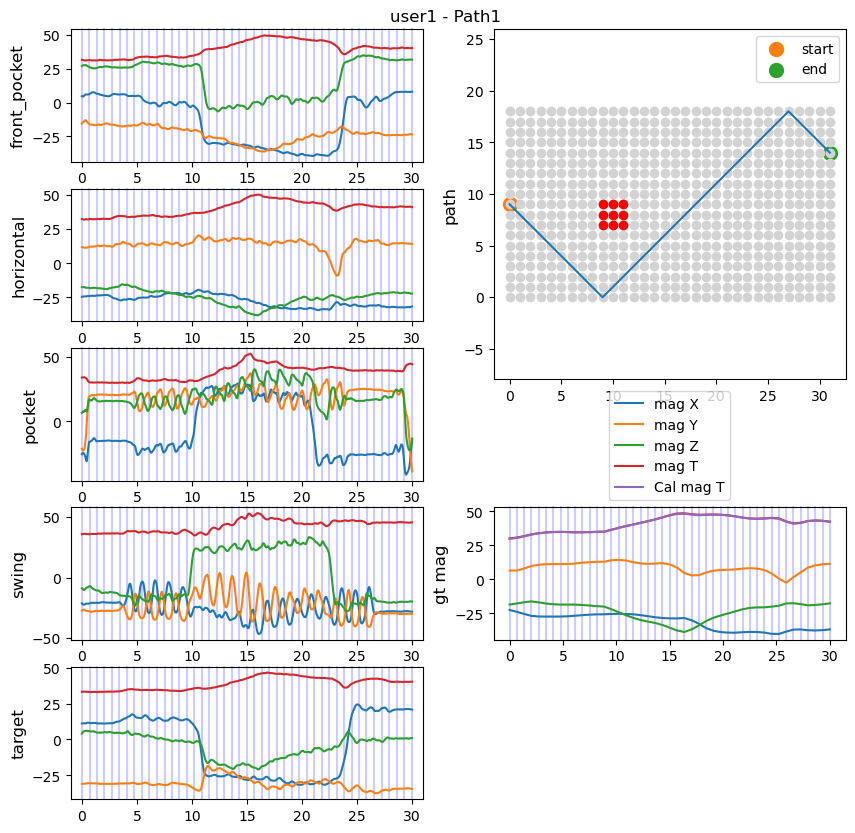

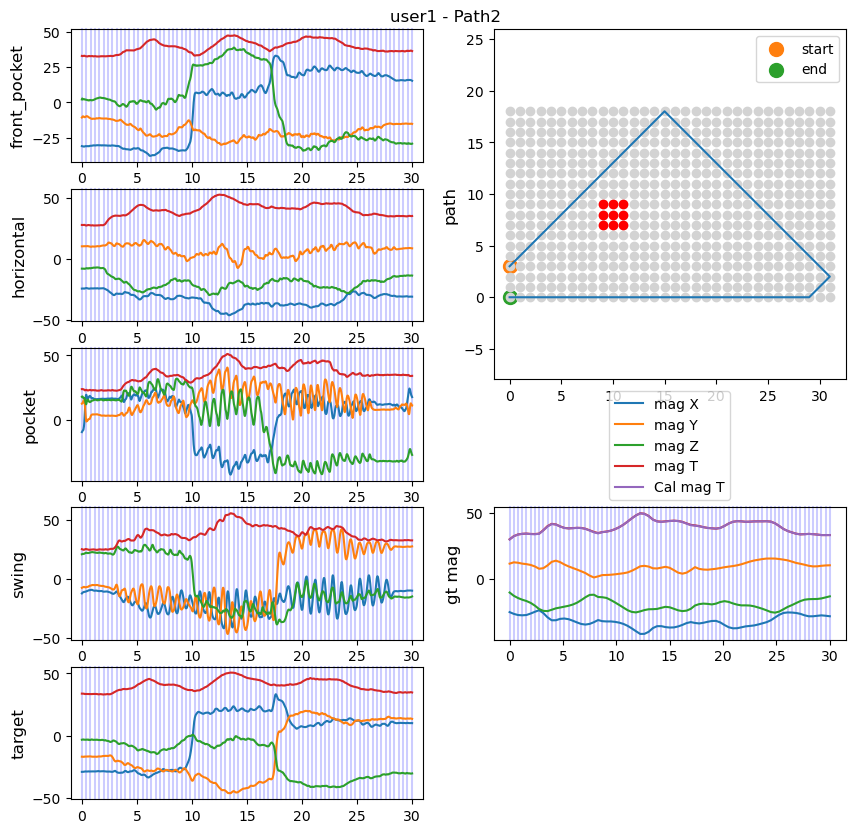

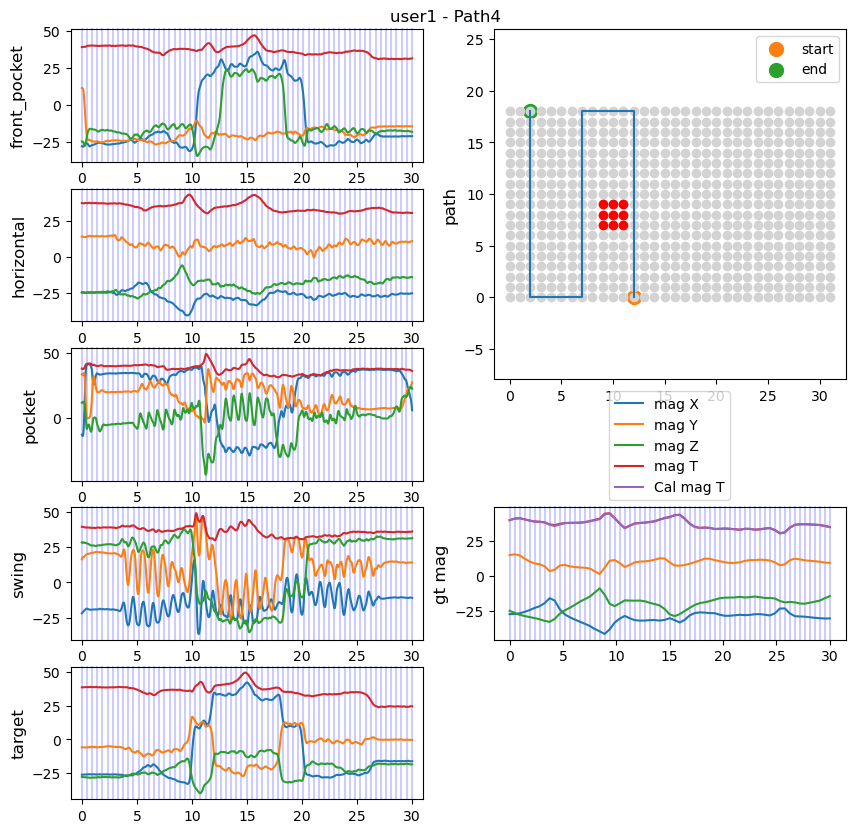

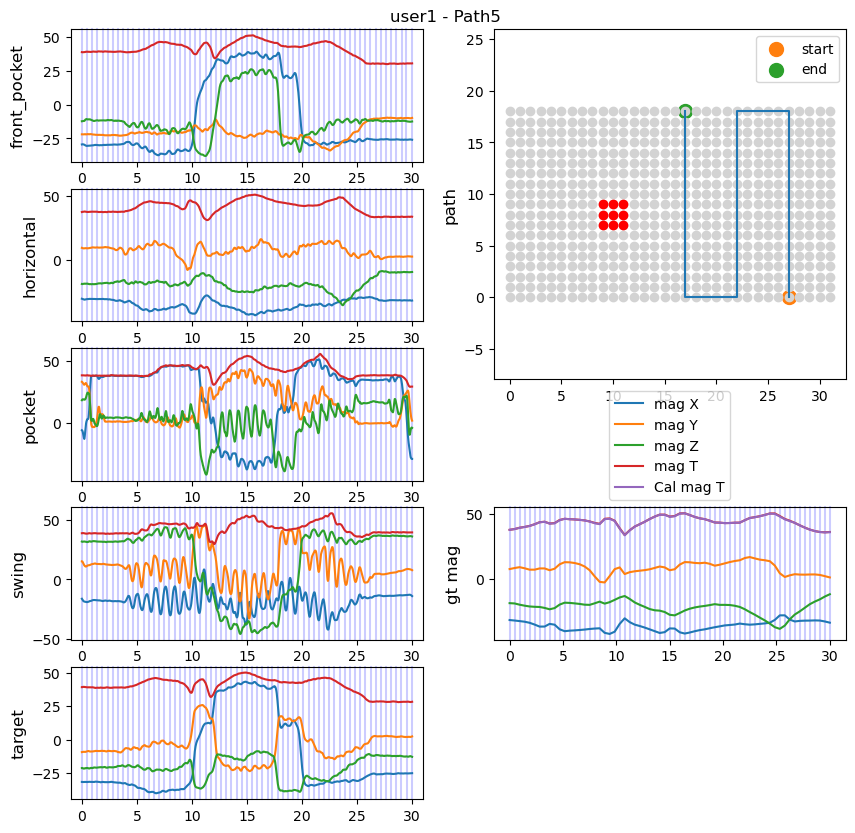

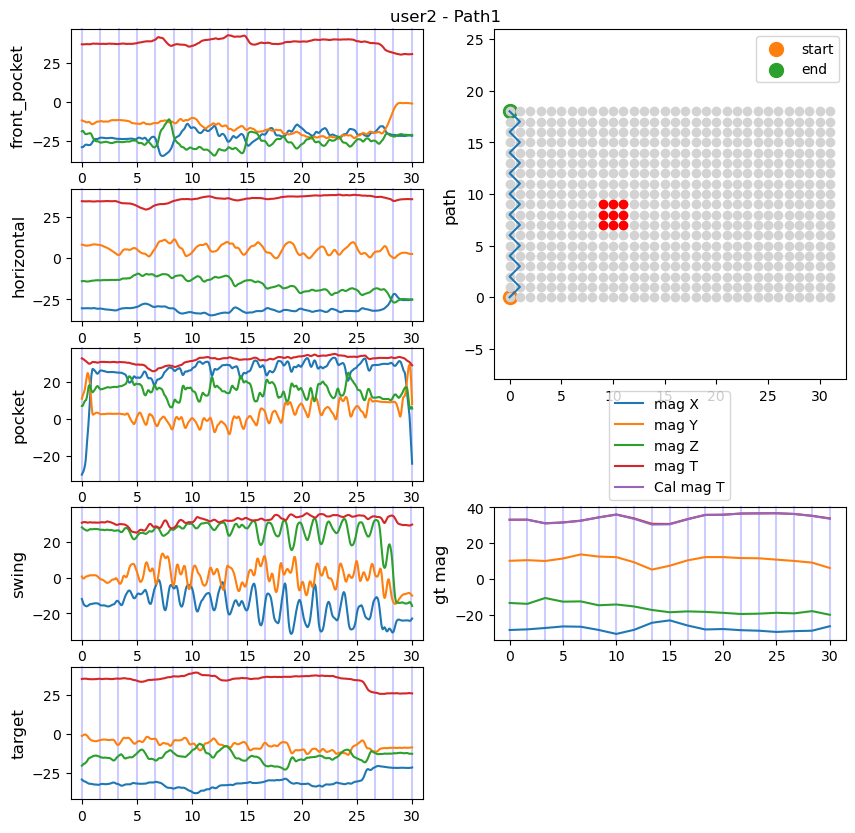

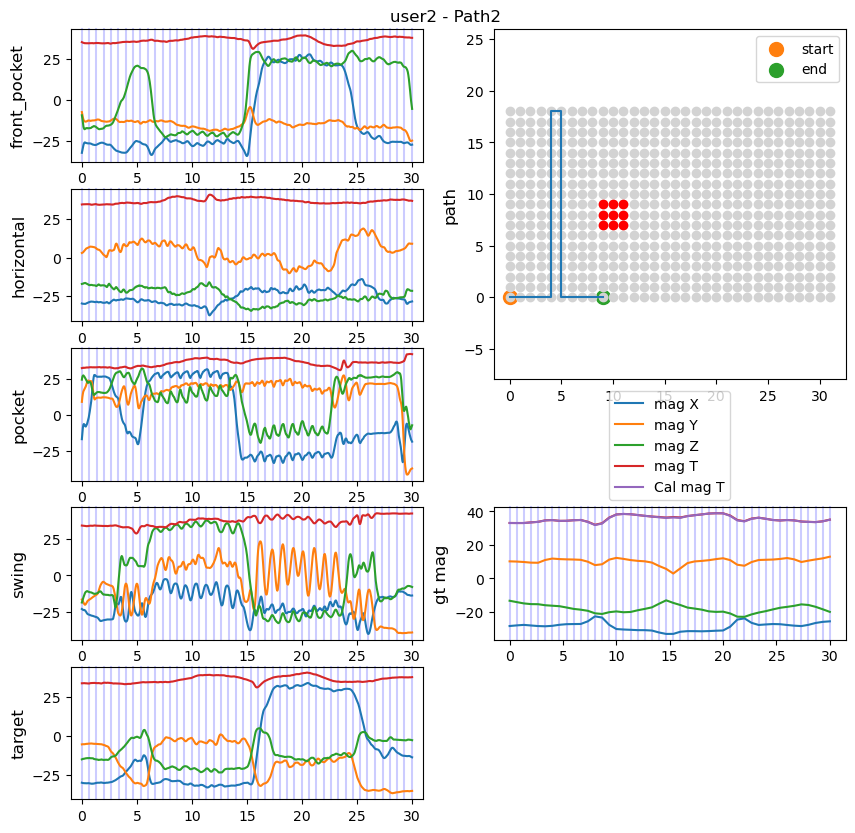

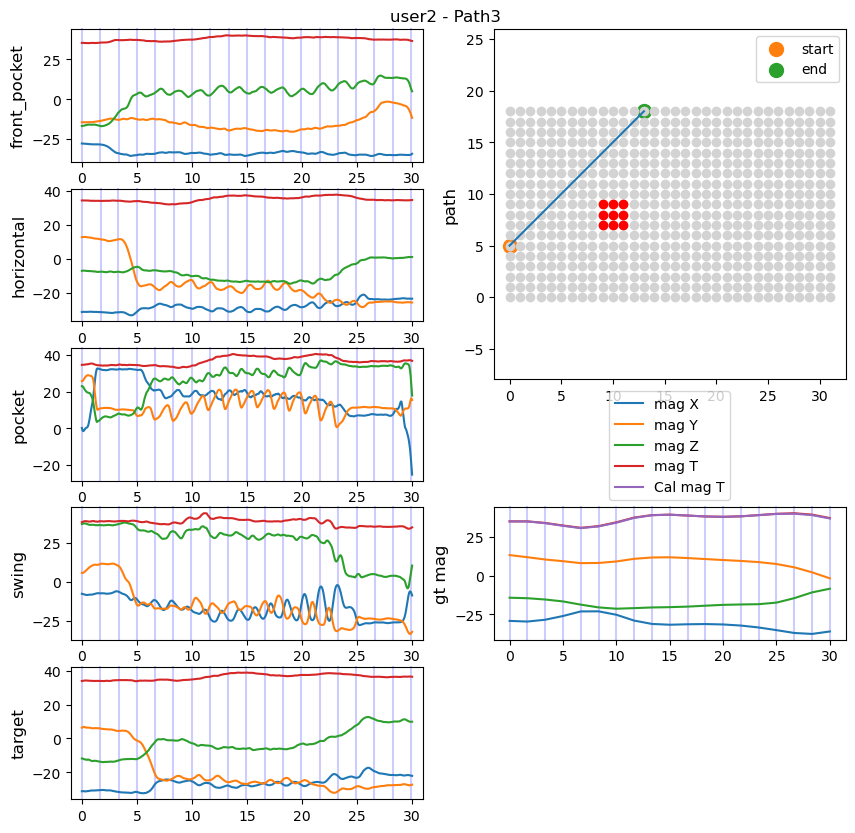

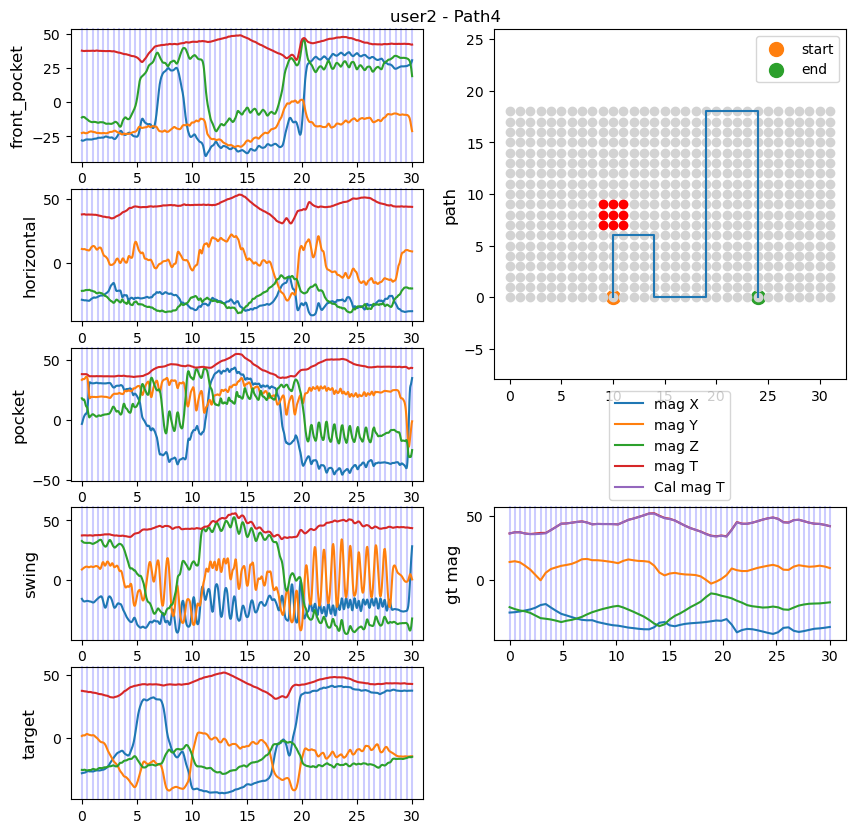

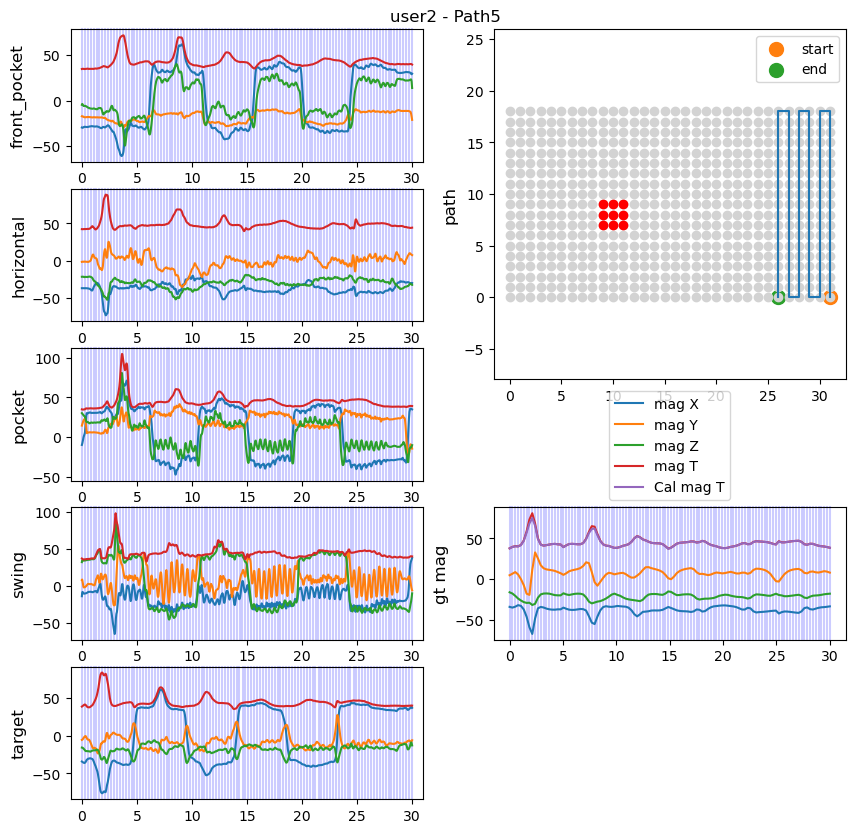

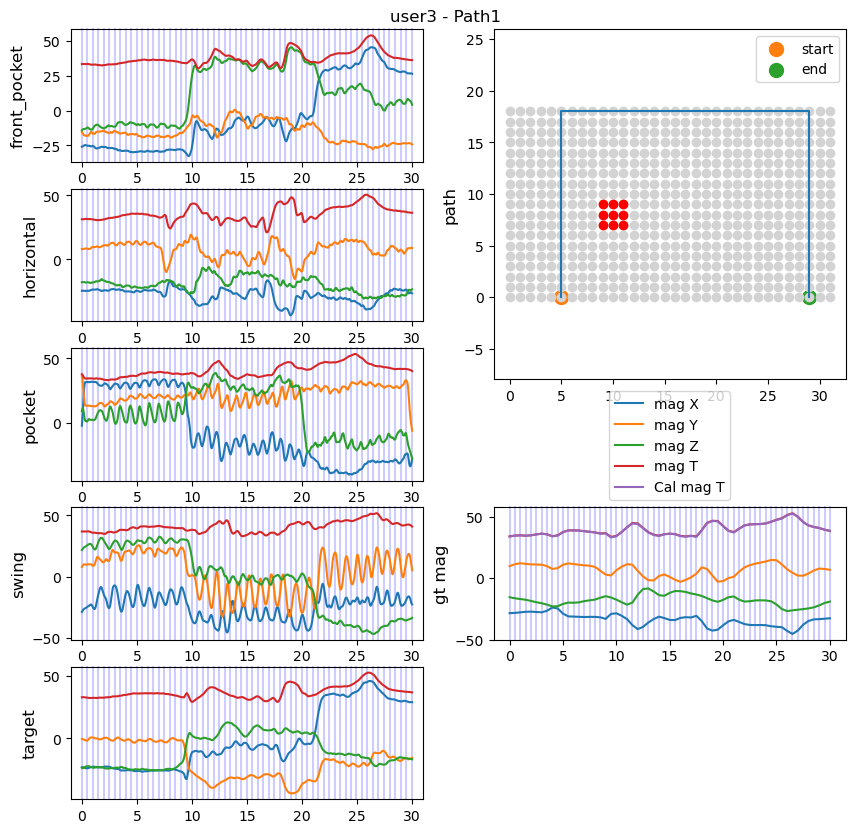

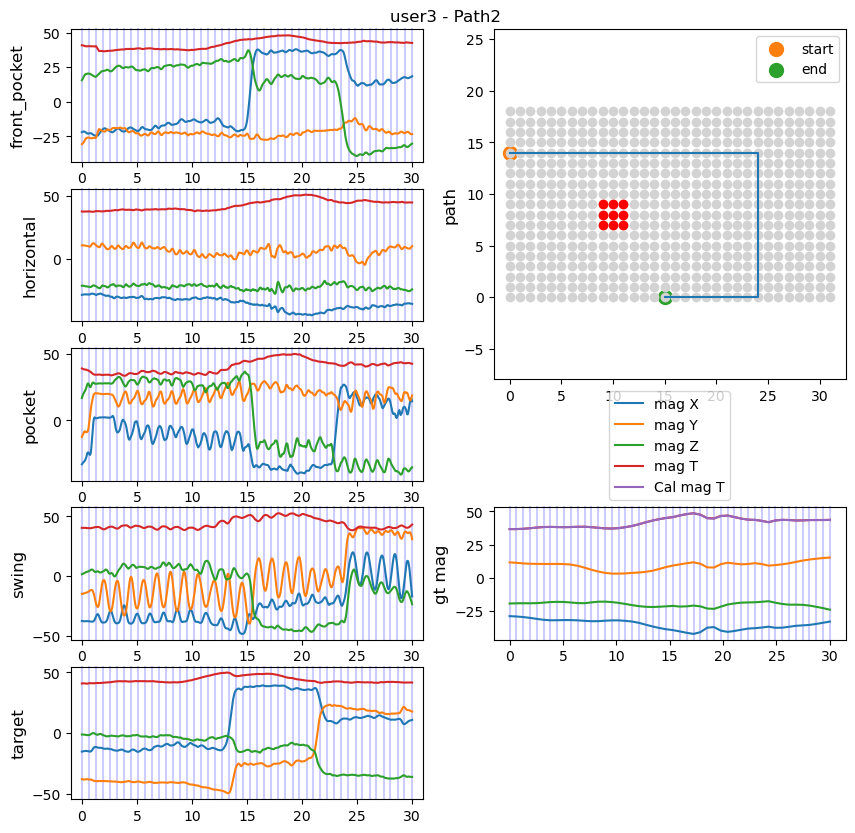

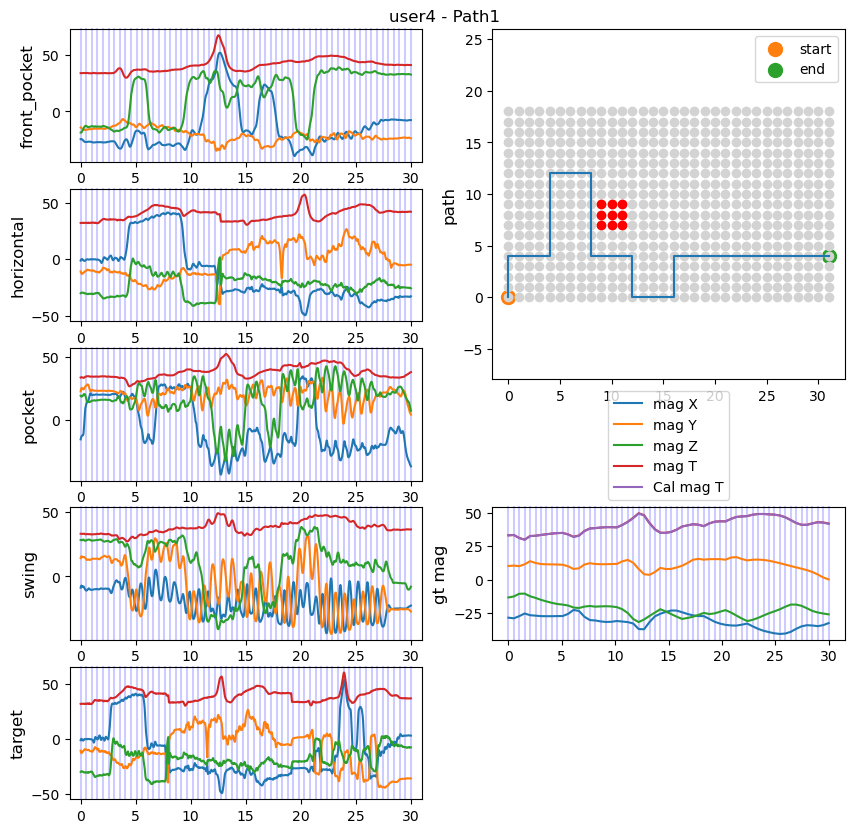

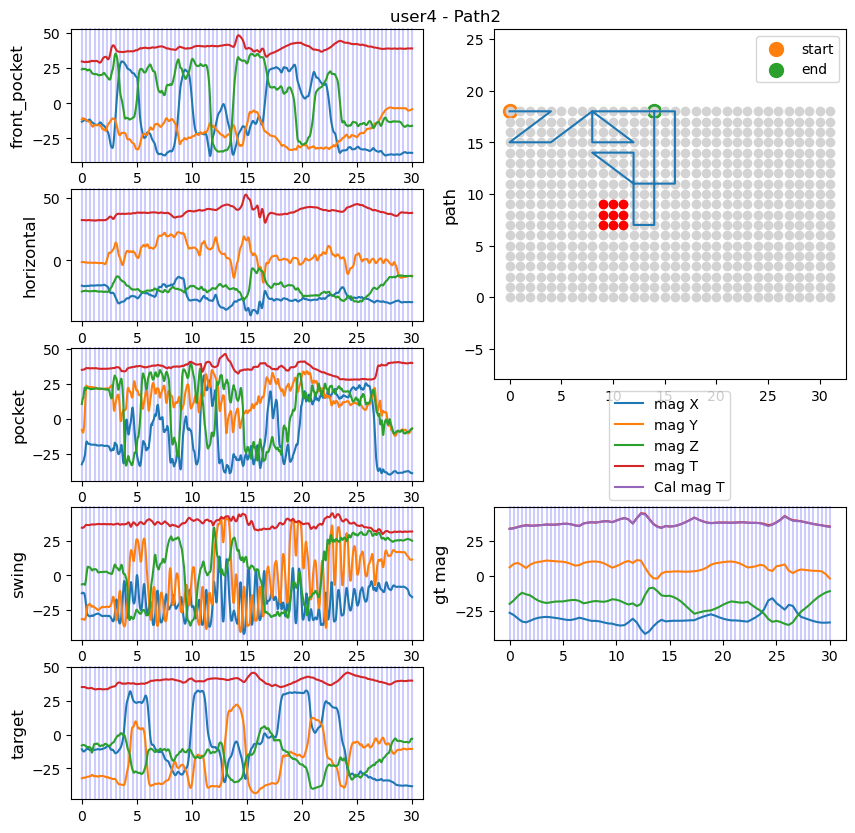

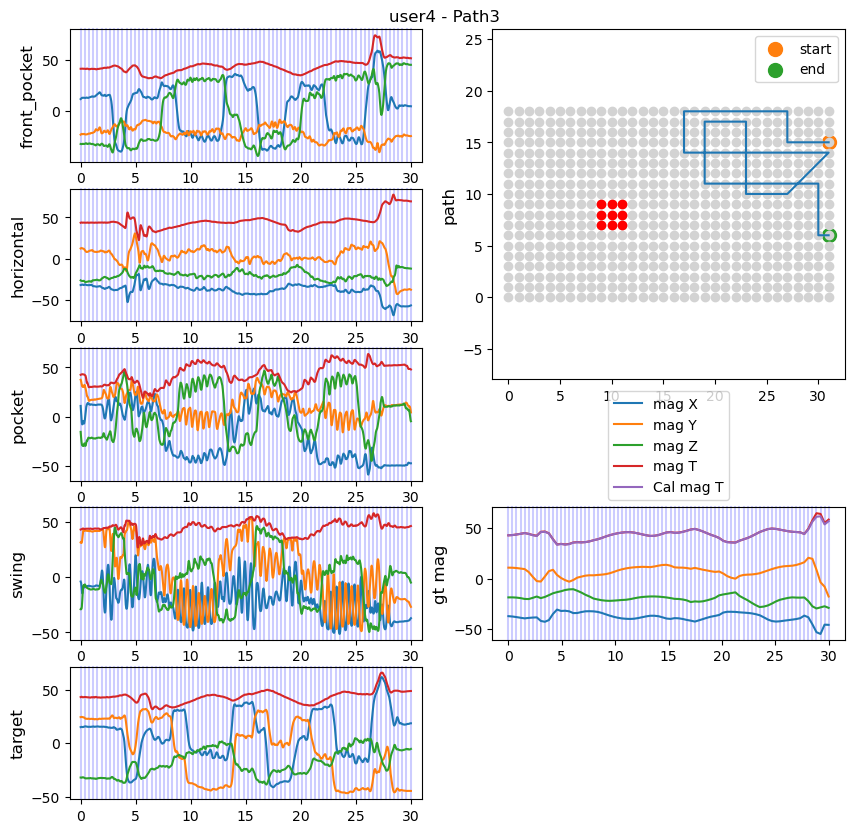

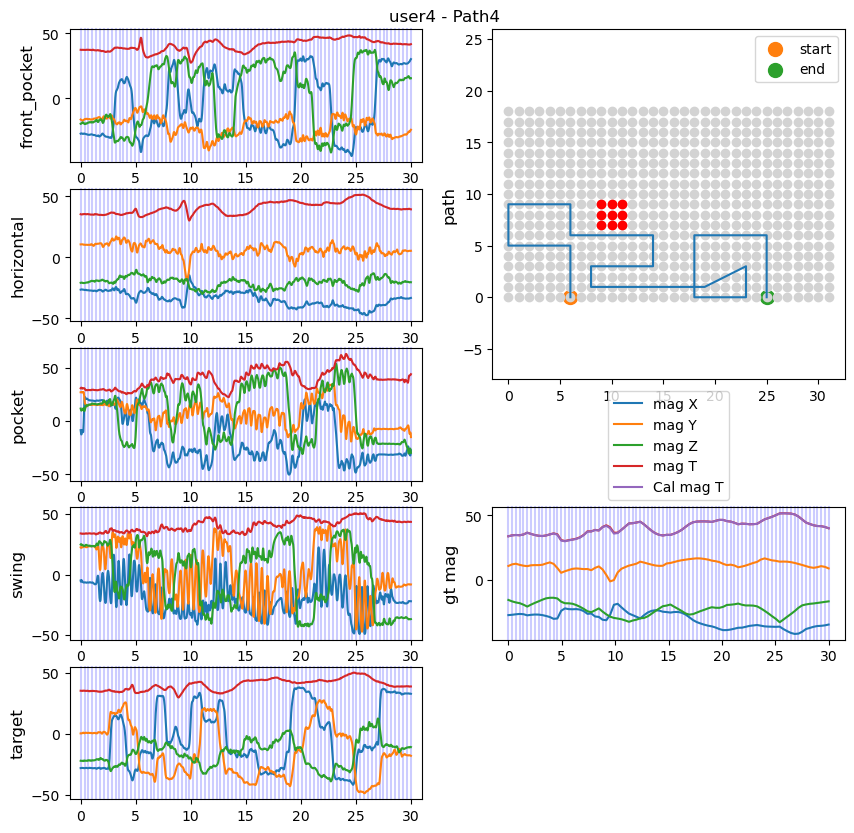

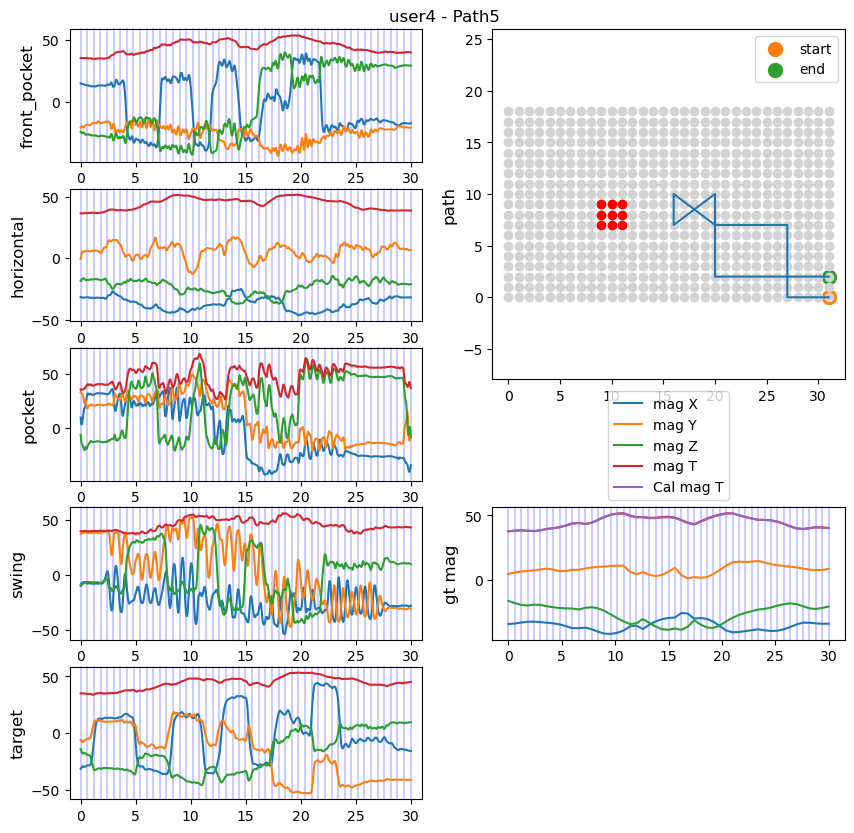

In [8]:
all_user_match_data = defaultdict(defaultdict)
grid_path_data = []
for user_name in all_data.keys():
    for path_name in all_data[user_name].keys():
        plt.figure(figsize=(10, 10))
        all_user_match_data[user_name][path_name] = defaultdict()
        
        for i, posture_name in enumerate(all_data[user_name][path_name].keys()):
            data = all_data[user_name][path_name][posture_name]
            path_point = np.array(user_path[user_name][path_name])
            
            time = data[:, 0] - data[:, 0][0]
            time = time / np.max(time) * 30
            
            ### plot posture mag
            plt.subplot(5, 2, 2 * (i + 1) - 1)
            plt.plot(time, data[:, 10])
            plt.plot(time, data[:, 11])
            plt.plot(time, data[:, 12])
            plt.plot(time, data[:, 13])

            plt.xlim([-1, 31])
            plt.ylabel(posture_name.split('/')[-1], fontsize=12)

            split_index = [i / (len(path_point) - 1) * (len(data) - 1) for i in range((len(path_point)))]
            split_index = np.round(split_index).astype(int)
            
            all_user_match_data[user_name][path_name][posture_name] = np.concatenate((path_point, data[split_index]), axis=-1)
            
            for idx in split_index:
                x = idx / len(data) * 30
                plt.axvline(x=x, ymin=0, ymax=1, c='blue', zorder=0, clip_on=False, alpha=0.2)
        
        ### plot path
        plt.subplot(2, 2, 2)
        plt.plot(path_point[:, 1], path_point[:, 0])
        plt.scatter(path_point[0, 1], path_point[0, 0], s=100, c='tab:orange', label='start')
        plt.scatter(path_point[-1, 1], path_point[-1, 0], s=100, c='tab:green', label='end')
        plt.scatter(grid.grid[:, :, 0], grid.grid[:, :, 1], color='lightgray')
        plt.scatter(grid.grid[9:12, 7:10, 0], grid.grid[9:12, 7:10, 1], color='red')

        plt.legend()
        plt.ylabel(f'path', fontsize=12)
        plt.axis('equal')
        
        ### plot gt mag
        plt.subplot(5, 2, 8)
        idx = path_point[:, [1, 0]]
        mag = np.array([grid[i] for i in idx])
        time = [i / (len(idx) - 1) * (30) for i in range((len(idx)))]
        
        plt.plot(time, mag[:, 0], label='mag X')
        plt.plot(time, mag[:, 1], label='mag Y')
        plt.plot(time, mag[:, 2], label='mag Z')
        plt.plot(time, mag[:, 3], label='mag T')
        plt.plot(time, np.sqrt(np.sum(np.power(mag[:, 0:3], 2), axis=-1)), label='Cal mag T')
        magH = np.sqrt(np.sum(np.power(mag[:, 0:2], 2), axis=-1)).reshape(-1, 1)
        
        all_user_match_data[user_name][path_name]['ref_mag'] = np.concatenate((idx[:, [1, 0]], mag, magH, mag[:, 2:3]), axis=-1)

#         plt.plot(time, moving_average(mag[:, 0], 3), label='mag X')
#         plt.plot(time, moving_average(mag[:, 1], 3), label='mag Y')
#         plt.plot(time, moving_average(mag[:, 2], 3), label='mag Z')
#         plt.plot(time, moving_average(mag[:, 3], 3), label='mag T')
#         plt.plot(time, moving_average(np.sqrt(np.sum(np.power(mag[:, 0:3], 2), axis=-1)), 3), label='Cal mag T')

        plt.ylabel(f'gt mag', fontsize=12)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
        
        for x in time:
            plt.axvline(x=x, ymin=0, ymax=1, c='blue', zorder=0, clip_on=False, alpha=0.2)
        
        # plt.axvline(x=0, ymin=-0.2, ymax=1, c='red', zorder=0, clip_on=False)
        plt.suptitle(f'{user_name} - {path_name}', x=0.5, y=0.9)
        plt.show()

In [11]:
np.save('all_user_match_data_5.npy', all_user_match_data)

In [12]:
print(all_user_match_data['user1']['Path1']['swing'].shape)

(45, 16)


In [13]:
print(all_user_match_data['user1']['Path1']['ref_mag'].shape)

(45, 8)


In [28]:
header = ['x', 'y', 'times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t']
for user_name in all_user_match_data.keys():
    for path_name in all_user_match_data[user_name].keys():
        os.makedirs(f'./CSV/{user_name.lower()}/{path_name.lower()}', exist_ok=True)
        for i, posture_name in enumerate(all_user_match_data[user_name][path_name].keys()):
            if posture_name == 'ref_mag':
                continue
            df = pd.DataFrame(all_user_match_data[user_name][path_name][posture_name], columns=header)
            df[['x', 'y']] = df[['x', 'y']] * 0.45
            df.to_csv(f'./CSV/{user_name.lower()}/{path_name.lower()}/{posture_name.lower()}.csv', index=False)

In [26]:
df[['x', 'y']] = df[['x', 'y']] * 0.45